# IMDB Sentiment Analysis Project #


A sentiment analysis project for IMDb movies aims to determine the overall opinion or emotion expressed in movie reviews. By analyzing the text of reviews, it identifies whether the sentiment is positive, negative, or neutral. 

## Libraries & Input ##

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('imdb.csv')
df.head(15)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [8]:
df.drop_duplicates()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [10]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [11]:
#split the dataset  
#train dataset
train_reviews= df.review[:40000]
train_sentiments=df.sentiment[:40000]
#test dataset
test_reviews=df.review[40000:]
test_sentiments=df.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

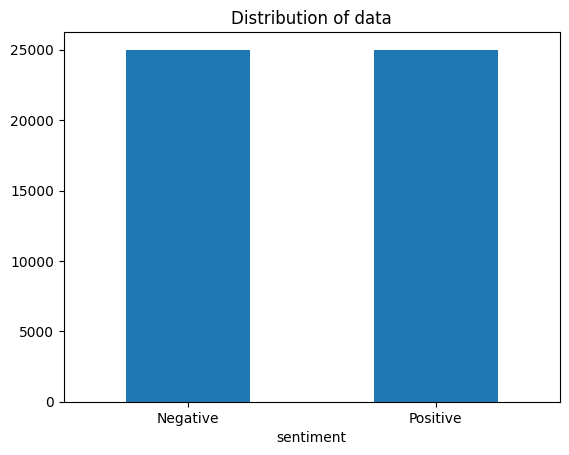

In [12]:
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [13]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [14]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

In [14]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]' #match any character that is not an alphanumeric character or a whitespace
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

In [15]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
df['review']=df['review'].apply(simple_stemmer)

In [16]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
df['review']=df['review'].apply(remove_stopwords)

{"didn't", 'very', 'that', 'all', 'do', "couldn't", "won't", 'own', 'i', 'those', 'm', 'our', 'over', 'ma', 'it', 'yourself', 'up', 'down', 'each', "haven't", "doesn't", 'off', 'other', 'ours', 'such', "you've", "you'd", 'and', 'd', 'he', 'yours', 'should', 'for', 'an', "it's", 'then', 'can', 'were', 'because', 'after', 'whom', 'so', 'y', 'theirs', 'shouldn', 'haven', 'the', 'don', 'am', 'was', 'a', 'shan', "mightn't", 'wasn', 'any', 'mightn', 'isn', "wasn't", "you'll", "aren't", 'my', 'herself', 'how', 'about', 's', 'him', 'themselves', 'before', 'below', 'did', 'no', 'hadn', 'out', 'some', 'in', 'them', "needn't", 'won', 'what', 'we', 'of', "wouldn't", 'itself', 'once', 'their', 'more', 'but', 'further', 'has', 'during', 'than', 'which', "that'll", 'doing', 'here', 'if', 'doesn', 'had', 'you', 'until', 'when', 'between', 'why', 'wouldn', 'above', 'she', 'through', 'as', 'his', 'to', "you're", 'now', 'not', "should've", 'nor', 'is', 'against', 'on', 'will', 'couldn', 'with', 'have', '

In [17]:
#normalized train reviews
norm_train_reviews=df.review[:40000]
norm_train_reviews[0]
#convert dataframe to string
#norm_train_string=norm_train_reviews.to_string()
#Spelling correction using Textblob
#norm_train_spelling=TextBlob(norm_train_string)
#norm_train_spelling.correct()
#Tokenization using Textblob
#norm_train_words=norm_train_spelling.words
#norm_train_words

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

In [18]:
#normalized train reviews
norm_train_reviews=df.review[:40000]
norm_train_reviews[0]

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

In [19]:
#Normalized test reviews
norm_test_reviews=df.review[40000:]
norm_test_reviews[45005]
##convert dataframe to string
#norm_test_string=norm_test_reviews.to_string()
#spelling correction using Textblob
#norm_test_spelling=TextBlob(norm_test_string)
#print(norm_test_spelling.correct())
#Tokenization using Textblob
#norm_test_words=norm_test_spelling.words
#norm_test_words

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

In [20]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6209089)
BOW_cv_test: (10000, 6209089)


In [21]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


In [22]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(df['sentiment'])
print(sentiment_data.shape)

(50000, 1)


In [23]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [24]:

#training the model logistic regression
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


In [25]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


In [26]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7512
lr_tfidf_score : 0.75


In [27]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [28]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3768 1239]
 [1249 3744]]
[[3663 1344]
 [1156 3837]]


In [31]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_bow = cross_val_score(lr, cv_train_reviews, train_sentiments, cv=kf, scoring='accuracy')
print("Cross-Validation Scores for Bag of Words Model:", scores_bow)
print("Mean Accuracy for Bag of Words Model:", np.mean(scores_bow))
print("Standard Deviation for Bag of Words Model:", np.std(scores_bow))

Cross-Validation Scores for Bag of Words Model: [0.500125 0.500125 0.500125 0.50025  0.50025 ]
Mean Accuracy for Bag of Words Model: 0.5001749999999999
Standard Deviation for Bag of Words Model: 6.123724356954551e-05


In [32]:
scores_tfidf = cross_val_score(lr, tv_train_reviews, train_sentiments, cv=kf, scoring='accuracy')
print("Cross-Validation Scores for TF-IDF Model:", scores_tfidf)
print("Mean Accuracy for TF-IDF Model:", np.mean(scores_tfidf))
print("Standard Deviation for TF-IDF Model:", np.std(scores_tfidf))

Cross-Validation Scores for TF-IDF Model: [0.500125 0.500125 0.500125 0.50025  0.50025 ]
Mean Accuracy for TF-IDF Model: 0.5001749999999999
Standard Deviation for TF-IDF Model: 6.123724356954551e-05


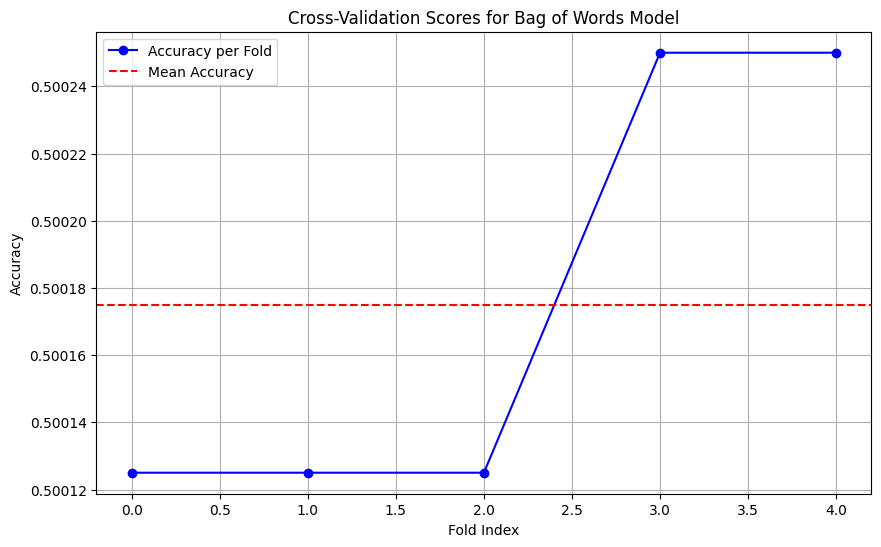

In [33]:
scores_bow = [0.500125, 0.500125, 0.500125, 0.50025, 0.50025]

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot the cross-validation scores
plt.plot(scores_bow, marker='o', linestyle='-', color='b', label='Accuracy per Fold')

# Adding horizontal line for the mean accuracy
mean_score = np.mean(scores_bow)
plt.axhline(y=mean_score, color='r', linestyle='--', label='Mean Accuracy')

# Adding labels and title
plt.xlabel('Fold Index')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for Bag of Words Model')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [38]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


In [39]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


In [43]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.751
mnb_tfidf_score : 0.7509


In [41]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [42]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3736 1271]
 [1219 3774]]
[[3729 1278]
 [1213 3780]]


<function matplotlib.pyplot.show(close=None, block=None)>

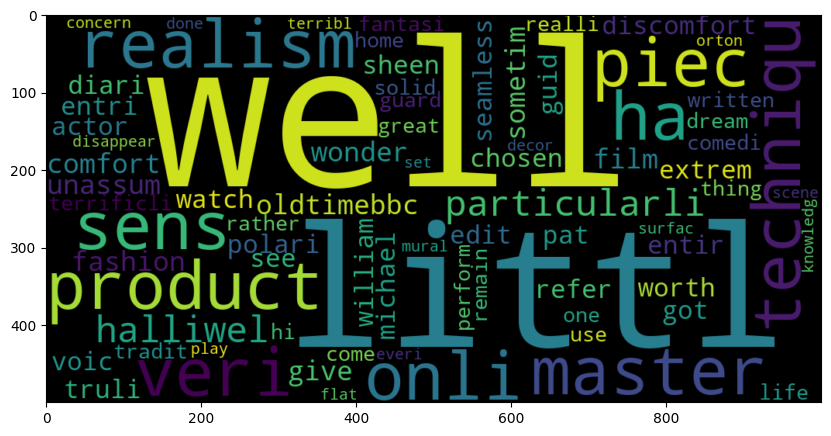

In [44]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

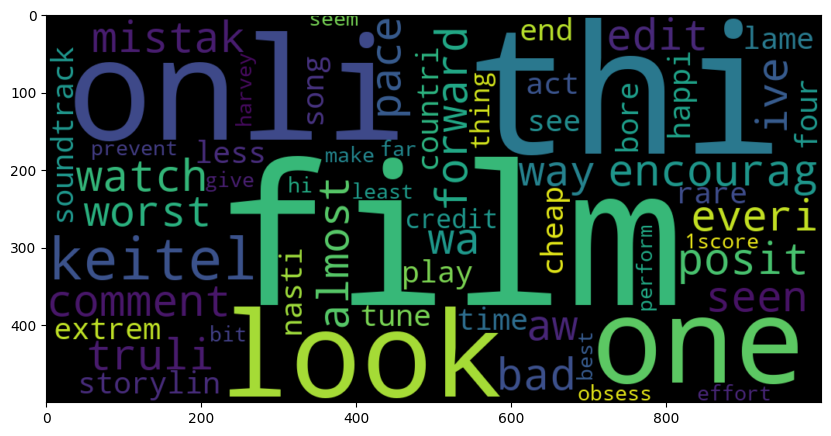

In [45]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show